# Imports

In [1]:
#!pip install -U scikit-learn

In [2]:
from Transformation import Transformation
import numpy as np
import math
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Input

In [3]:
transformation = Transformation()

# Create objects
stl_file_path = "3d_models/stl/Handle.stl"
mesh_data = transformation.stl_to_mesh(stl_file_path)
graph = transformation.mesh_to_graph(mesh_data)

transformation.print_graph_properties(graph, display_graph=False, display_labels=False)

Number of nodes: 5999
Number of edges: 17991


In [4]:
print(graph._node)

{(75.0252, -0.66553295, 3.8): {'index_triangle': {0, 6820, 164, 165, 6821, 6822}}, (75.01418, -0.49935842, 16.7): {'index_triangle': {0, 1, 165, 370, 371, 372}}, (75.0, 0.0, 3.8): {'index_triangle': {0, 1, 2, 6658, 6659, 11415, 11416, 11417, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6495}}, (75.00158, 0.16653232, 16.7): {'index_triangle': {1, 2, 3, 372, 373, 374}}, (75.0252, 0.66553295, 3.8): {'index_triangle': {2, 6659, 3, 4, 6660}}, (75.03937, 0.8314692, 16.7): {'index_triangle': {3, 4, 5, 374, 375, 376}}, (75.10067, 1.3272538, 3.8): {'index_triangle': {6660, 6661, 4, 5, 6, 6662}}, (75.12734, 1.4916434, 16.7): {'index_triangle': {5, 6, 7, 376, 377, 378}}, (75.22596, 1.9813722, 3.8): {'inde

# Point Sampler

### DevConv

In [5]:
def relu(array):
    return np.maximum(array, 0)

def sigmoid(array):
    return 1 / (1 + np.exp(-array))

In [6]:
class DevConv():
    def __init__(self, graph, output_dimension):
        self.graph = graph
        self.list_node = list(graph._node)

        self.W_phi = np.random.random((output_dimension))      #change
        self.W_theta = np.array([1, 2, 3])  # change
    
    def forward(self, previous_inclusion_score, return_flatten=True):
        list_inc_score = np.zeros((len(self.list_node), len(self.W_phi)))
        for index_current_node, (current_node, dict_neigh) in enumerate(self.graph._adj.items()):
            # print(index_current_node, " | ", current_node, " | ", dict_neigh)
            neigh_distances = np.zeros(shape=len(dict_neigh))
            for index_neigh, neigh_node in enumerate(dict_neigh.keys()):
                neigh_distances[index_neigh] = np.linalg.norm(np.multiply(self.W_theta, np.array(current_node) - np.array(neigh_node))) # norm(W_theta * (xi - xj))
            list_inc_score[index_current_node] = self.W_phi * np.max(neigh_distances)                                   # W_phi * max(distance)    

        # return if no previous inclusion score
        if len(previous_inclusion_score)==0:
            if return_flatten:
                list_inc_score = list_inc_score.flatten()
            return list_inc_score
        
        # mean the rows if more than one column
        if list_inc_score.shape[1]!=1:
            list_inc_score = np.mean(list_inc_score, axis=1)

        # array of array to array
        if len(list_inc_score.shape)==2:
            if list_inc_score.shape[1]==1:
                list_inc_score = list_inc_score.flatten()

        # Return the mean of previous and current inclusion score
        return np.mean(np.array([previous_inclusion_score, list_inc_score], dtype=np.float64), axis=0)
        

In [7]:
devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]))
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = sigmoid(inclusion_score)
print(inclusion_score)
print(inclusion_score.shape)

[25.44103479 25.44758669 25.44109827 ...  7.99253185 22.93495969
  7.99388304]
[22.65410782 22.65994199 22.65416434 ...  7.11699346 20.42255962
  7.11819664]
[1.         1.         1.         ... 0.99993332 1.         0.99993343]
(5999,)


### Multinomial Sampling

In [8]:
normalized_inclusion_score = inclusion_score / np.sum(inclusion_score)  # normalize for multinomial sampling
normalized_inclusion_score = np.round(normalized_inclusion_score, 8)    # round to remove float imprecision

number_throws = 500     # small:more randomness    |   big:less randomness
mult_sampling = np.random.multinomial(number_throws, normalized_inclusion_score)
print(mult_sampling)

[1 0 0 ... 0 0 0]


In [9]:
target_number_triangles = 10
target_number_point = min(len(graph._node), target_number_triangles*3)   # number of points for the simplification     #TODO Change to nb of triangles

index_k_nodes = np.argpartition(mult_sampling, -target_number_point)[-target_number_point:]
list_k_nodes = np.array(list(graph._node.keys()))[index_k_nodes]
list_k_nodes = [tuple(e) for e in list_k_nodes]
print(list_k_nodes)

[(83.627205, 5.2797017, 94.484726), (75.09724, 1.3272538, 3.7739456), (75.622025, -3.2518802, 81.2326), (75.07823, -1.3272538, 81.26335), (82.27729, -8.672658, -3.4772909), (84.41676, 6.2811418, 92.82873), (78.5203, 7.0402236, 16.7), (75.0, 7.138877, -10.145526), (63.0, -2.464716, -13.447791), (39.0, 2.1432736, 3.535009), (63.0, -1.1623888, -13.722893), (78.38337, -6.9390492, 81.37731), (76.60997, -8.672658, -6.3649364), (77.34079, 6.2811418, 95.97916), (85.80854, -8.535009, 2.088095), (75.0, -1.6554987, -13.642877), (90.23091, 5.7970243, 83.612335), (63.0, -4.303499, 82.32407), (89.39652, 5.7970243, 86.72631), (75.283104, -2.6241417, 81.4831), (87.20604, 8.114116, 3.8), (83.39875, 5.7970243, 94.13294), (78.38166, -8.535009, -6.6076717), (92.44722, 0.99710757, 1.9662229), (75.00263, -0.66553295, 3.7749352), (86.18796, -8.348472, 0.8021954), (89.470764, 5.2797017, 87.6428), (83.60757, -8.348472, -3.9502904), (81.30835, -8.348472, -5.9140086), (75.0252, -0.66553295, 3.8)]


# KNN

In [10]:
XYZ = [list(e) for e in list_k_nodes]
print(XYZ)

[[83.627205, 5.2797017, 94.484726], [75.09724, 1.3272538, 3.7739456], [75.622025, -3.2518802, 81.2326], [75.07823, -1.3272538, 81.26335], [82.27729, -8.672658, -3.4772909], [84.41676, 6.2811418, 92.82873], [78.5203, 7.0402236, 16.7], [75.0, 7.138877, -10.145526], [63.0, -2.464716, -13.447791], [39.0, 2.1432736, 3.535009], [63.0, -1.1623888, -13.722893], [78.38337, -6.9390492, 81.37731], [76.60997, -8.672658, -6.3649364], [77.34079, 6.2811418, 95.97916], [85.80854, -8.535009, 2.088095], [75.0, -1.6554987, -13.642877], [90.23091, 5.7970243, 83.612335], [63.0, -4.303499, 82.32407], [89.39652, 5.7970243, 86.72631], [75.283104, -2.6241417, 81.4831], [87.20604, 8.114116, 3.8], [83.39875, 5.7970243, 94.13294], [78.38166, -8.535009, -6.6076717], [92.44722, 0.99710757, 1.9662229], [75.00263, -0.66553295, 3.7749352], [86.18796, -8.348472, 0.8021954], [89.470764, 5.2797017, 87.6428], [83.60757, -8.348472, -3.9502904], [81.30835, -8.348472, -5.9140086], [75.0252, -0.66553295, 3.8]]


In [11]:
def connect_extended_graph(XYZ, number_neigh=15):
    # Create the nearest neighbors object
    _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
    # Create the graph from the nearest points
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(indices):
        for index_current_node in range(len(poly)):
            current_node = tuple(XYZ[poly[index_current_node]])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(XYZ[poly[index_other_node]])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_poly'] = set()
                extended_graph.nodes[current_node]['index_poly'].add(index_poly)
    return extended_graph

In [12]:
extended_graph = connect_extended_graph(XYZ)

Number of nodes: 30
Number of edges: 277


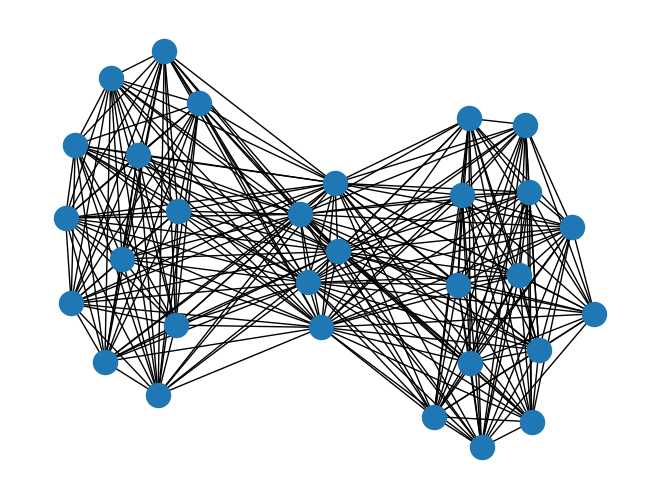

In [13]:
transformation.print_graph_properties(graph=extended_graph, display_graph=True, display_labels=False)

# Edge Predictor

In [14]:
devconv = DevConv(extended_graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]), return_flatten=False)
print(inclusion_score.shape)

(30, 64)


In [15]:
"""
inclusion_score = [[f_1_1  , f_1_2  , ..., f_63_1  ],
                    ...,
                   [f_1_M-1, f_1_M-1, ..., f_63_M-1]]
M = number of points
64 = hidden dimensions
"""
from numpy import mean


f1i = np.mean(inclusion_score)
f1j = np.mean(inclusion_score)
wq = np.random.randint(100, size=(64,1))
wk = np.random.randint(100, size=(1,64))

f1i_wq = f1i*wq
f1j_wk = f1j*wk

wq_wk = int(np.matmul(f1j_wk, f1i_wq)) 

expo = np.exp(wq_wk)



C:\Users\Arthur\AppData\Local\Temp\ipykernel_4064\73126498.py:21: RuntimeWarning: overflow encountered in exp
  expo = np.exp(wq_wk)


### Sparse Attention

# Face Candidates

#### Inputs

In [16]:
adjacency = nx.adjacency_matrix(extended_graph)
S = np.random.rand(target_number_point, target_number_point)
print(adjacency)
print(S)

  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (0, 9)	1
  (0, 10)	1
  (0, 11)	1
  (0, 12)	1
  (0, 13)	1
  (0, 14)	1
  (0, 15)	1
  (0, 16)	1
  (1, 0)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (1, 5)	1
  (1, 6)	1
  (1, 7)	1
  (1, 8)	1
  (1, 9)	1
  :	:
  (28, 19)	1
  (28, 20)	1
  (28, 21)	1
  (28, 22)	1
  (28, 23)	1
  (28, 24)	1
  (28, 25)	1
  (28, 26)	1
  (28, 27)	1
  (28, 29)	1
  (29, 12)	1
  (29, 14)	1
  (29, 15)	1
  (29, 16)	1
  (29, 17)	1
  (29, 18)	1
  (29, 19)	1
  (29, 20)	1
  (29, 21)	1
  (29, 22)	1
  (29, 23)	1
  (29, 24)	1
  (29, 26)	1
  (29, 27)	1
  (29, 28)	1
[[4.54391219e-01 5.59806102e-02 4.00721677e-01 3.47353635e-01
  8.43995789e-03 7.30051756e-01 8.31988506e-01 7.15757469e-01
  8.31827305e-01 5.22707681e-01 7.90963213e-01 3.25284421e-01
  4.07479043e-02 3.88443026e-01 3.36508345e-01 1.41280706e-01
  8.75489916e-01 8.87828297e-01 9.76647490e-02 7.12622051e-01
  2.84629846e-01 2.70848513e-01 3.67824651e-01 2.56978199e-01
  5.58527848e-0

In [17]:
A_s = np.zeros((target_number_point,target_number_point))

for i in range(target_number_point):
    for j in range(target_number_point):
        A_s[i,j] = np.matmul(np.matmul(S[i,:], adjacency.A), S[j,:][np.newaxis].T)

print(A_s)  # symmétrique
print(A_s.shape)

[[102.007468   101.78469261 127.02694854  98.48869829 129.1901599
  117.15253589 130.41151373 134.83090507 126.9571188  123.6132356
  116.74909132 104.09154495 125.92720185 111.20368983 124.92198334
  141.78312776 102.32412414 108.35048157 122.55275376 128.94438771
  107.76902632 131.6684618  139.28486737 138.72638436 134.33499811
  151.89292115 141.2894587  115.69130784 106.77691311 126.16515659]
 [101.78469261  99.85117079 121.06036814  96.8792914  128.0971443
  115.63724782 127.95967254 130.95604236 122.33163369 118.20450872
  112.02189278 102.16149908 125.895895   109.06985925 123.67058088
  139.56036348 102.67426338 106.06292477 121.60232399 129.87046602
  107.0111963  128.61646787 135.0018658  135.19547245 134.20393174
  146.30936472 137.74463125 109.35676319 107.49315503 121.21185935]
 [127.02694854 121.06036814 152.66473277 116.82268764 156.33928336
  140.88063211 157.89986899 163.03693006 154.92200357 149.82002248
  142.57175105 127.74292478 152.82533681 134.98010233 148.54130

c:\Users\Arthur\miniconda3\envs\meshPFE\lib\site-packages\scipy\sparse\_base.py:719: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.13.0. Use `.toarray()` instead.
  warn(np.VisibleDeprecationWarning(


# Face Classifier

### TriConv

#### Inputs

In [18]:
triangles = list(nx.simple_cycles(extended_graph, length_bound=3))  # [triangle0, triangle1,...] | triangle0 = [node1,node2,node3] | node1 = (x ,y ,z)
print(triangles)
print(np.array(triangles).shape)    #nb_triangle, 3 nodes, 3 dimensions par node

[[(83.627205, 5.2797017, 94.484726), (83.39875, 5.7970243, 94.13294), (84.41676, 6.2811418, 92.82873)], [(83.627205, 5.2797017, 94.484726), (83.39875, 5.7970243, 94.13294), (77.34079, 6.2811418, 95.97916)], [(83.627205, 5.2797017, 94.484726), (83.39875, 5.7970243, 94.13294), (89.470764, 5.2797017, 87.6428)], [(83.627205, 5.2797017, 94.484726), (83.39875, 5.7970243, 94.13294), (89.39652, 5.7970243, 86.72631)], [(83.627205, 5.2797017, 94.484726), (83.39875, 5.7970243, 94.13294), (90.23091, 5.7970243, 83.612335)], [(83.627205, 5.2797017, 94.484726), (83.39875, 5.7970243, 94.13294), (75.07823, -1.3272538, 81.26335)], [(83.627205, 5.2797017, 94.484726), (83.39875, 5.7970243, 94.13294), (75.283104, -2.6241417, 81.4831)], [(83.627205, 5.2797017, 94.484726), (83.39875, 5.7970243, 94.13294), (75.622025, -3.2518802, 81.2326)], [(83.627205, 5.2797017, 94.484726), (83.39875, 5.7970243, 94.13294), (78.38337, -6.9390492, 81.37731)], [(83.627205, 5.2797017, 94.484726), (83.39875, 5.7970243, 94.13294)

In [19]:
p_init = np.zeros((len(triangles)))

for index_triangle, triangle in enumerate(triangles):
    i = list(dict(extended_graph._node).keys()).index(triangle[0])
    j = list(dict(extended_graph._node).keys()).index(triangle[1])
    k = list(dict(extended_graph._node).keys()).index(triangle[2])
    p_init[index_triangle] = (A_s[i,j] + A_s[i,k] + A_s[j,k])/3
print(p_init)

[116.6240031   99.0508941  119.6906656  ... 135.57179794 144.98983308
 157.06905877]


#### Calculate barycenter

In [20]:
barycenters = list()

for _, triangle in enumerate(triangles):
    b_x = (triangle[0][0] + triangle[1][0] + triangle[2][0]) / 3
    b_y = (triangle[0][1] + triangle[1][1] + triangle[2][1]) / 3
    b_z = (triangle[0][2] + triangle[1][2] + triangle[2][2]) / 3
    barycenters.append([b_x, b_y, b_z])

print(barycenters)
print(len(barycenters))

[[83.81423950195312, 5.785956064860026, 93.81547037760417], [81.45558166503906, 5.785956064860026, 94.86561075846355], [85.4989013671875, 5.452142715454102, 92.08682250976562], [85.47416178385417, 5.624583562215169, 91.78133138020833], [85.75228881835938, 5.624583562215169, 90.7433369954427], [80.70139567057292, 3.249823888142904, 89.96034749348958], [80.76968383789062, 2.8175280888875327, 90.03358968098958], [80.88265991210938, 2.608281930287679, 89.95009358723958], [81.80311075846355, 1.3792255719502766, 89.99833170572917], [76.67531840006511, 2.257742245992025, 90.3139139811198], [81.8487548828125, 6.0389830271403, 68.43922424316406], [84.74399820963542, 6.3969472249348955, 64.13922627766927], [80.70773315429688, 4.134660085042317, 64.13053894042969], [80.6837158203125, 3.470397631327311, 64.13922627766927], [80.6761983235677, 3.470397631327311, 64.13086954752605], [81.794921875, 5.947328567504883, 94.43086751302083], [85.83824666341145, 5.613515218098958, 91.65207926432292], [85.81

In [21]:
def connect_triangle_graph(XYZ, number_neigh=20):
    # Create the nearest neighbors object
    _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
    # Create the graph from the nearest points
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(indices):
        for index_current_node in range(len(poly)):
            current_node = tuple(XYZ[poly[index_current_node]])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(XYZ[poly[index_other_node]])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_poly'] = set()
                extended_graph.nodes[current_node]['index_poly'].add(index_poly)
    return extended_graph

In [22]:
graph_triangles = connect_triangle_graph(barycenters)
print(graph_triangles._node)

{(83.81423950195312, 5.785956064860026, 93.81547037760417): {'index_poly': {0, 1, 225, 226, 134, 135, 136, 15, 120, 29, 30, 31}}, (83.47958374023438, 5.613515218098958, 92.70222981770833): {'index_poly': {0, 1, 2, 3, 225, 226, 134, 135, 136, 227, 15, 16, 120, 121, 29, 30, 31}}, (83.40343221028645, 5.785956064860026, 92.5849609375): {'index_poly': {0, 1, 2, 3, 225, 226, 134, 135, 136, 227, 15, 120, 29, 30, 31}}, (83.454833984375, 5.785956064860026, 92.396728515625): {'index_poly': {0, 1, 2, 3, 225, 226, 134, 135, 136, 227, 15, 16, 17, 120, 121, 29, 30, 31}}, (83.37868245442708, 5.958396911621094, 92.2794698079427): {'index_poly': {0, 1, 2, 3, 225, 226, 134, 135, 136, 227, 15, 16, 120, 121, 29, 30, 31}}, (83.74277242024739, 5.947328567504883, 92.15022786458333): {'index_poly': {0, 1, 2, 3, 4, 134, 135, 136, 15, 16, 17, 29, 30, 31, 225, 226, 227, 120, 121, 122}}, (83.71802775065105, 6.11976941426595, 91.84473673502605): {'index_poly': {0, 1, 2, 3, 4, 134, 135, 136, 15, 16, 17, 29, 30, 31,

In [23]:
transformation.print_graph_properties(graph=graph_triangles, display_graph=False, display_labels=False)

Number of nodes: 1455
Number of edges: 34357


#### calculate e norm matrix

In [24]:
diff_vectors = list()

for _, triangle in enumerate(triangles):
    e_ij = np.linalg.norm(np.array(triangle[0]) - np.array(triangle[1]))
    e_ik = np.linalg.norm(np.array(triangle[0]) - np.array(triangle[2]))
    e_jk = np.linalg.norm(np.array(triangle[1]) - np.array(triangle[2]))
    diff_vectors.append([e_ij, e_ik, e_jk])
print(diff_vectors)
print(len(diff_vectors))

[[0.66600746, 2.0901232, 1.7238607], [0.66600746, 6.538748, 6.3515167], [0.66600746, 8.99773, 8.902748], [0.66600746, 9.682234, 9.530554], [0.66600746, 12.731277, 12.544385], [0.66600746, 17.074589, 16.900082], [0.66600746, 17.3533, 17.227833], [0.66600746, 17.677378, 17.57211], [0.66600746, 18.670832, 18.710096], [0.66600746, 25.791487, 25.643303], [0.66600746, 77.97207, 77.59642], [0.66600746, 90.79956, 90.442825], [0.66600746, 91.19664, 90.849556], [0.66600746, 91.28559, 90.9501], [0.66600746, 91.31263, 90.97708], [2.0901232, 6.538748, 7.7456183], [2.0901232, 8.99773, 7.3102436], [2.0901232, 9.682234, 7.8912525], [2.0901232, 12.731277, 10.907822], [2.0901232, 17.074589, 16.698915], [2.0901232, 17.3533, 17.071938], [2.0901232, 17.677378, 17.398165], [2.0901232, 18.670832, 18.501629], [2.0901232, 25.791487, 26.09713], [2.0901232, 77.97207, 76.360504], [2.0901232, 90.79956, 89.09126], [2.0901232, 91.19664, 89.678024], [2.0901232, 91.28559, 89.791824], [2.0901232, 91.31263, 89.819046], 

#### Calculate r

In [25]:
r_matrix = np.zeros((len(triangles),len(triangles), 5))

for n, triangle_n in enumerate(triangles):
    for m, triangle_m in enumerate(triangles):
        t_min = min(diff_vectors[n]) - min(diff_vectors[m])
        t_max = max(diff_vectors[n]) - max(diff_vectors[m])
        diff_bary = np.array(barycenters[n]) - np.array(barycenters[m])
        r_matrix[n, m] = [t_min, t_max, diff_bary[0], diff_bary[1], diff_bary[2]]

print(r_matrix)
print(r_matrix.shape)   # nb_triangles, nb_triangles, 5dim/triangles

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00 -4.44862461e+00  2.35865784e+00  0.00000000e+00
   -1.05014038e+00]
  [ 0.00000000e+00 -6.90760708e+00 -1.68466187e+00  3.33813349e-01
    1.72864787e+00]
  ...
  [-1.12752366e+00 -3.99552689e+01  1.91503601e+01  1.08074210e+01
    9.69613368e+01]
  [-1.57541876e+01 -3.99552689e+01  1.96870219e+01  5.53690902e+00
    9.82215328e+01]
  [-1.56707468e+01 -3.82769814e+01  2.02775828e+01  5.58279188e+00
    9.81406212e+01]]

 [[ 0.00000000e+00  4.44862461e+00 -2.35865784e+00  0.00000000e+00
    1.05014038e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00 -2.45898247e+00 -4.04331970e+00  3.33813349e-01
    2.77878825e+00]
  ...
  [-1.12752366e+00 -3.55066452e+01  1.67917023e+01  1.08074210e+01
    9.80114772e+01]
  [-1.57541876e+01 -3.55066452e+01  1.73283641e+01  5.53690902e+00
    9.92716732e+01]
  [-1.56707468e+01 -3.3828353

#### Calculate f

In [26]:
# MLP * 3 
f_final = p_init    # TODO

import torch
final_scores = torch.nn.functional.softmax(torch.tensor(f_final))
final_scores = final_scores.numpy()
print(final_scores.sum())
print(final_scores.shape)
print(final_scores)

1.0000000000000004
(1455,)
[2.44463413e-37 5.70570882e-45 5.24866042e-36 ... 4.14129928e-29
 5.09726611e-25 8.98004209e-20]


C:\Users\Arthur\AppData\Local\Temp\ipykernel_4064\4023725568.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  final_scores = torch.nn.functional.softmax(torch.tensor(f_final))


# Simplified Mesh

In [27]:
selected_triangles_indexes = np.argpartition(final_scores, -target_number_point)[-target_number_point:] 
selected_triangles = np.array(triangles)[selected_triangles_indexes]
print(selected_triangles.shape) # number triangles, number points, number dimensions(x,y,z)

(30, 3, 3)


In [28]:
def create_triangle_graph(XYZ):
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(XYZ):
        for index_current_node in range(len(poly)):
            current_node = tuple(poly[index_current_node])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(poly[index_other_node])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_triangle'] = set()
                extended_graph.nodes[current_node]['index_triangle'].add(index_poly)
                if len(extended_graph.nodes[tuple(poly[index_other_node])])==0:
                    extended_graph.nodes[tuple(poly[index_other_node])]['index_triangle'] = set()
                extended_graph.nodes[tuple(poly[index_other_node])]['index_triangle'].add(index_poly)
    return extended_graph

In [29]:
simplified_final_graph = create_triangle_graph(selected_triangles)
print(simplified_final_graph._node)

{(75.0252, -0.66553295, 3.8): {'index_triangle': {0, 1, 5, 6, 7, 8, 9, 10, 15, 17, 20, 21, 23, 29}}, (81.30835, -8.348472, -5.9140086): {'index_triangle': {0, 4, 6, 12, 13, 15, 17, 18, 26, 27}}, (75.0, 7.138877, -10.145526): {'index_triangle': {0, 1, 2, 14, 19, 20, 21, 27}}, (83.60757, -8.348472, -3.9502904): {'index_triangle': {1, 3, 6, 8, 9, 12, 18, 19, 22, 25, 28}}, (86.18796, -8.348472, 0.8021954): {'index_triangle': {2, 7, 11, 13, 25}}, (92.44722, 0.99710757, 1.9662229): {'index_triangle': {2, 3, 4, 5, 7, 8, 10, 11, 13, 14, 15, 16, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29}}, (78.5203, 7.0402236, 16.7): {'index_triangle': {16, 3, 29}}, (85.80854, -8.535009, 2.088095): {'index_triangle': {24, 10, 4, 28}}, (75.09724, 1.3272538, 3.7739456): {'index_triangle': {5}}, (75.0, -1.6554987, -13.642877): {'index_triangle': {9, 11, 12, 14, 16, 17, 21, 22, 23, 24, 26}}}


In [30]:
transformation.print_graph_properties(graph=simplified_final_graph, display_graph=False, display_labels=False)

Number of nodes: 10
Number of edges: 32


In [31]:
simplified_final_mesh = transformation.graph_to_mesh(simplified_final_graph)

transformation.mesh_to_display_vtk(mesh_data)
transformation.mesh_to_display_vtk(simplified_final_mesh)